# Modelling

Feature engineering, model training, tuning, selection and explanability.

# 0. Load Packages and Define Helper Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, uniform
from preprocessing import preprocess_df, get_amenities
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression, Lasso # baseline
from sklearn.ensemble import RandomForestRegressor #good
from xgboost import XGBRegressor #good
from lightgbm import LGBMRegressor # goodest

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [38]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
set_config(display="diagram")
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from keras import backend
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

In [3]:
def fit_and_score(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'],n_jobs=2, verbose=1, cv = 5) 
    
    # Test metrics
    pred_test= model.predict(X_test)
    test_MSE = mean_squared_error(y_test, pred_test)
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')
    print('Test R-sq', round(model.score(X_test, y_test),4))
    print('Test MSE:', round(test_MSE,4))
    
    return model


def random_search_pipe(model, grid, X_train, y_train):
    
    search = RandomizedSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

def grid_search_pipe(model, grid, X_train, y_train):
    
    search = GridSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

In [4]:
def check_impact(df):
    
    print('Check accuracy at this step...')
    
    random_state = 12

    dep_var = ['price_log']
    to_drop = ['id', 'host_id', 'property_type', 'price', 'host_since', 'first_review', 'last_review']

    X = df.fillna(0).drop(dep_var + to_drop, axis = 1)
    y = df['price_log'].ravel()

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state = random_state)

    # Get numeric and categorical columns
    num_cols = list(X.select_dtypes(include=np.number).columns)
    cat_cols = list(set(X.columns)-set(X[num_cols].columns))

    # Preprocess
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols ),
            ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
        ]
        , remainder='passthrough'
    )

    
    lgbm_best = Pipeline([('preprocess', preprocessor),
                    ('regressor', LGBMRegressor(random_state = random_state,
                                               boosting_type = 'gbdt',
                                               colsample_bytree = 0.5,
                                               max_bin = 10,
                                               max_depth = 12,
                                               n_estimators = 350,
                                               num_leaves = 30,
                                               subsample = 0.50))
                   ])


    model = fit_and_score(model = lgbm_best, 
                                 X_train = X_train, 
                                 X_test = X_test,
                                 y_train = y_train,
                                 y_test = y_test)
    
    print('')
    print('Shape of X: {}'.format(np.shape(X)))
    

# 1. Load and Preprocess

In [5]:
data = pd.read_csv('data/listings.csv.gz')
df = preprocess_df(data = data, verbose = True)

Columns dropped ['listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_about', 'host_picture_url', 'calendar_last_scraped', 'license', 'host_url', 'host_thumbnail_url', 'host_verifications', 'name', 'description', 'neighborhood_overview', 'host_name', 'calendar_updated', 'bathrooms', 'host_neighbourhood', 'neighbourhood', 'host_listings_count', 'beds', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'neighbourhood_cleansed']
Before removing inactive listings, length = 66641
After removing inactive listings, length = 33046
After removing price = 0 listings, length = 33037
Features bathroom_num and bathroom_sharing extracted.
Int and float mv filled with 0, object m

In [6]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'bathroom_num', 'bathroom_sharing', 'price_log'],
      dtype='object')

In [7]:
df = get_amenities(data = df, 
                   num_amenities =80, # best is to call 80 amenities and select from there
                  verbose = True)

[('wifi', 32096), ('essentials', 31414), ('smoke alarm', 30603), ('heating', 29750), ('kitchen', 29321), ('hangers', 28388), ('long term stays allowed', 28070), ('iron', 27868), ('washer', 26852), ('hair dryer', 26387), ('hot water', 25305), ('shampoo', 23394), ('carbon monoxide alarm', 22656), ('dedicated workspace', 22473), ('dishes and silverware', 21126), ('cooking basics', 20499), ('refrigerator', 20424), ('bed linens', 18340), ('tv', 17925), ('microwave', 17588), ('oven', 17256), ('stove', 15436), ('dryer', 14012), ('first aid kit', 12522), ('fire extinguisher', 12352), ('coffee maker', 11651), ('dishwasher', 11275), ('private entrance', 9889), ('extra pillows and blankets', 9725), ('luggage dropoff allowed', 8066), ('host greets you', 7248), ('lockbox', 7143), ('bathtub', 7013), ('elevator', 6878), ('free parking on premises', 6310), ('shower gel', 6301), ('paid parking off premises', 5864), ('hot water kettle', 5738), ('backyard', 5698), ('free street parking', 5674), ('lock on

In [8]:
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_outdoor dining area,amenities_children’s books and toys,amenities_cleaning before checkout,amenities_clothing storage,amenities_clothing storage: closet,amenities_mini fridge,amenities_private fenced garden or backyard,amenities_building staff,amenities_paid street parking off premises,amenities_nespresso machine
1,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,0,0,0,0,0,0,0,0,0
4,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,0,0,0,0,0,0,0,0,0
9,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,0,1,0,0,0,1,0,0,0
11,38995,167281,2020-02-21,0,1.0,1,1,0.0,51.47860,-0.06114,...,0,0,0,0,0,0,0,0,0,0
14,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df['room_type'].value_counts()

Entire home/apt    20083
Private room       12646
Shared room          142
Hotel room           139
Name: room_type, dtype: int64

## 1.1 Baseline Before Feature Engineering

In [10]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.7s finished


Train R-sq 0.8698
Train MSE: 0.0813

CV R-sq 0.7841
CV MSE: 0.1348

Test R-sq 0.7954
Test MSE: 0.1225

Shape of X: (33010, 113)


# 2. Feature Engineering

## 2.1 Host Duration

In [11]:
# Last scraped date = 2021-12-07 (7th Dec)
df['host_duration'] = (pd.to_datetime('2021-12-10') - df['host_since']).dt.days

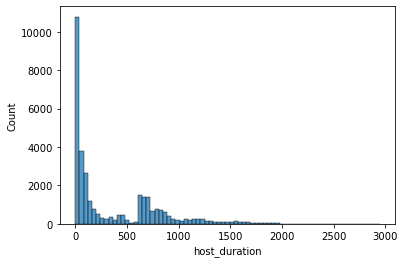

In [12]:
sns.histplot(df['host_duration'])
plt.show()

In [13]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.3s finished


Train R-sq 0.8701
Train MSE: 0.0811

CV R-sq 0.7861
CV MSE: 0.1336

Test R-sq 0.7954
Test MSE: 0.1225

Shape of X: (33010, 114)


## 2.2 managed_property

- Binary (0,1). 1 if properties managed by host id exceed the 95th percentile.

In [14]:
# Understand how many properties are potentially property managed

percentiles=[0.80,0.85,0.90,0.95]
percentile_rooms=[]
room_above=[]

for p in percentiles:
   percentile_rooms.append(df.host_id.value_counts().quantile(p))

print('Understand managed property percentiles beyond P75\n')
print(pd.DataFrame({'percentile':percentiles,'rooms_threshold':percentile_rooms}))

property_count=pd.DataFrame(df.groupby(['host_id'])['host_id'].count())
property_count.columns=['properties']
print('*****EXTRACT PROPERTIES MANAGED BY HOST ID *****')
property_count

Understand managed property percentiles beyond P75

   percentile  rooms_threshold
0        0.80              1.0
1        0.85              2.0
2        0.90              2.0
3        0.95              3.0
*****EXTRACT PROPERTIES MANAGED BY HOST ID *****


,properties
host_id,
4775,7
5653,1
6774,3
9323,1
10657,2
...,...
433334823,1
433435234,2
433572694,1


In [15]:
property_count['prop_managed']=property_count['properties'].map(lambda x: 1 if x>=percentile_rooms[3] else 0)
df=pd.merge(df,property_count,on='host_id',how='inner')
df.prop_managed.value_counts()

0    22496
1    10514
Name: prop_managed, dtype: int64

In [16]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.2s finished


Train R-sq 0.8743
Train MSE: 0.0775

CV R-sq 0.7879
CV MSE: 0.1309

Test R-sq 0.7871
Test MSE: 0.1336

Shape of X: (33010, 116)


## 2.3 Occupancy Rate

- short term proxy: avail30
- mid term proxy: avail60-90
- long term proxy: avail365

In [17]:
cols=['availability_30','availability_60', 'availability_90','availability_365']
df[cols].describe()

,availability_30,availability_60,availability_90,availability_365
count,33010.000000,33010.000000,33010.000000,33010.000000
mean,6.882187,18.561527,31.615177,121.371191
std,9.251464,20.881292,33.341793,134.103803
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,7.000000,17.000000,66.000000
75%,12.000000,37.000000,65.000000,248.000000
max,30.000000,60.000000,90.000000,365.000000


In [18]:
df['occ_30D']=1-round(df.availability_30/30,2)
df['occ_6090D']=((1-round(df.availability_60/60,2))+(1-round(df.availability_90/90,2)))/2
df['occ_365']=1-round(df.availability_365/365,2)

df=df.drop(cols,axis=1) # do not drop

In [19]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'amenities_private fenced garden or backyard',
       'amenities_building staff',
       'amenities_paid street parking off premises',
       'amenities_nespresso machine', 'host_duration', 'properties',
       'prop_managed', 'occ_30D', 'occ_6090D', 'occ_365'],
      dtype='object', length=123)

In [20]:
check_impact(df=df)

Check accuracy at this step...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.3s finished


Train R-sq 0.873
Train MSE: 0.0783

CV R-sq 0.7854
CV MSE: 0.1325

Test R-sq 0.7872
Test MSE: 0.1335

Shape of X: (33010, 115)


## 2.4 Location Variables

In [21]:
# Load computed location features
location_features = ['station', 'station_dist','walking_distance']
df = df.merge(pd.read_csv('computed_features/london_nearest_tube.csv')[['id']+location_features],left_on='id', right_on='id',how='left')
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_nespresso machine,host_duration,properties,prop_managed,occ_30D,occ_6090D,occ_365,station,station_dist,walking_distance
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,634,1,0,1.0,1.000,0.99,South Kensington,805.406363,0.0
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,635,3,1,1.0,1.000,1.00,Brent Cross,302.665825,1.0
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,692,3,1,0.9,0.960,0.99,Brent Cross,346.564965,1.0
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,0,630,3,1,1.0,1.000,1.00,Brent Cross,361.025714,1.0
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,485,1,0,0.8,0.335,0.07,Shepherds Bush Market,449.743591,3.0


## 2.5 Sentiment

In [22]:
############## Add sentiment features #################
import pandas as pd
df_sentiment = pd.read_csv('computed_features/nc_eng_with_sent.csv')
# df_sentiment = df_sentiment.groupby('listing_id').mean()
# df_sentiment = df_sentiment.reset_index()
df=pd.merge(df,df_sentiment,left_on='id', right_on='listing_id',how='left')
df = df.drop(['listing_id'], axis = 1)
df = df.fillna(df.mean())
df.head()

,id_x,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,walking_distance,Unnamed: 0,id_y,reviewer_id,comments_len,key_reviewer,negative,neutral,positive,compound
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0.0,1.0,8.029375e+07,2.695406e+07,78.062500,0.075000,0.016000,0.682400,0.301550,0.900261
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,1.0,3.0,8.898858e+07,3.434179e+07,61.970588,0.127451,0.011020,0.607324,0.381667,0.941062
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,1.0,10.0,1.066726e+08,3.536433e+07,71.552239,0.074627,0.007433,0.627463,0.365134,0.961803
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,1.0,16621.0,4.596262e+08,1.034197e+08,44.500000,0.136364,0.003682,0.558909,0.437409,0.953786
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,3.0,7.0,3.235218e+08,8.901368e+07,86.068966,0.000000,0.007931,0.707483,0.284621,0.927310


# 3. Feature selection

In [23]:
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.preprocessing import LabelEncoder


def regression_scores(model, X_train, X_test, y_train, y_test):
    
     # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5) 
    
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')

def run_model(X, y):
    
    random_state = 42
    
    # Automatic label encoding
    le = LabelEncoder()
    for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = le.fit_transform(X[column_name])
        else:
            pass

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    
    # Train Model
    rf = RandomForestRegressor(n_jobs = -1, random_state = random_state)
    
    # Fit Model
    rf.fit(X_train, y_train)

    # Score model on test set
    regression_scores(rf, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [24]:
## LGBMReressor

from numpy import sort
from sklearn.feature_selection import SelectFromModel
#Get a function to generally see feature importance
def run_lgbm(X,y):
    random_state = 42
    
     # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    lgbm = LGBMRegressor(n_jobs=-1,random_state=random_state)
    lgbm.fit(X_train,y_train)
    print('Scores run on full number of features')
    regression_scores(lgbm, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

    # plot feature importance
    # choice of gain, weighted or cover
    # use gain; weighted might give too much bias to numerical or high cardinality. 
    # this post explains it well:
    # https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
    plot_importance(lgbm, importance_type="gain")
    plt.show()
    
    ## From prof's sample code
    # The following block of codes will try to use importance score for features selection

    # Fit model using each importance as a threshold
    thresholds = sort(lgbm.feature_importances_) # sort the importance score

    # select feaures by using importance score as threshold
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(lgbm, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = LGBMRegressor(n_jobs=-1, random_state = 42)
        selection_model.fit(select_X_train, y_train)
        # eval model
        cv_score = cross_validate(selection_model, select_X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5)
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        #test_MSE = mean_squared_error(y_train, y_pred)
        #print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
        #print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
        print("Thresh=%.3f, n=%d, CV MSE: %.2f" % (thresh, select_X_train.shape[1], round(-np.mean(cv_score['test_neg_mean_squared_error']),4)))
    
    return selection

In [52]:
## modify the func to run at threshold = xx
import eli5
from eli5.sklearn import PermutationImportance

## LGBMReressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

from numpy import sort
from sklearn.feature_selection import SelectFromModel

#Re-write function to accept threshold value and also output the test MSE on the selected subset
def thresh_run_lgbm(X,y,thresh):
    random_state = 42
    
     # Automatic label encoding
    le = LabelEncoder()
    for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = le.fit_transform(X[column_name])
        else:
            pass
        
     # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    lgbm = LGBMRegressor(n_jobs=-1,random_state=random_state)
    lgbm.fit(X_train,y_train)
    

    # Fit model using each importance as a threshold
    thresholds = sort(lgbm.feature_importances_) # sort the importance score

    # select features using threshold
    selection = SelectFromModel(lgbm, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = LGBMRegressor(n_jobs=-1, random_state = 42)
    selection_model.fit(select_X_train, y_train)
    # eval model on cv
    cv_score = cross_validate(selection_model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
   
   # CV_MSE = mean_squared_error(y_test, cv_score)
    
    print('Score from selected subset of features')
    #Score of subset features (not all features)
    regression_scores(selection_model, X_train = select_X_train, X_test = select_X_test, y_train = y_train, y_test = y_test)
    
    print("Thresh=%.3f, n=%d, CV:%.2f" % (thresh, select_X_train.shape[1],round(-np.mean(cv_score['test_neg_mean_squared_error']),4)))
    
   
    ##carry on from selection 
    include = selection.get_support()
    headers = X_all.columns

    fs = pd.DataFrame({'cols':headers,'include':include})
    filters = (fs.include==True)
    selected_col = fs[filters].cols.tolist()
    
    return selected_col

In [53]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [54]:
drop_cols=['id_x','host_id','host_has_profile_pic','price','price_log','id_y','reviewer_id','host_since','key_reviewer','first_review','last_review']
X_all=df.drop(drop_cols,axis=1)
y_all=df['price_log']

In [55]:
lgbm_col = thresh_run_lgbm(X_all,y_all,5)

Score from selected subset of features
Train R-sq 0.8357
Train MSE: 0.1011

CV R-sq 0.7801
CV MSE: 0.1353

Thresh=5.000, n=68, CV:0.14


In [56]:
fs_cols=lgbm_col
df_fs= df[fs_cols]
df.columns

Index(['id_x', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'walking_distance', 'Unnamed0', 'id_y', 'reviewer_id', 'comments_len',
       'key_reviewer', 'negative', 'neutral', 'positive', 'compound'],
      dtype='object', length=135)

# 4. Models

In [57]:
# Format columns
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [58]:
df.columns.tolist()

['id_x',
 'host_id',
 'host_since',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'bathroom_num',
 'bathroom_sharing',
 'price_log',
 'amenities_wifi',
 'amenities_essentials',
 'amenities_smokealarm',
 'amenities_heating',
 'amenities_kitchen',
 'amenities_hangers',
 'amenities_longtermstaysallowed',
 'amenities_iron',
 'amenities_washer',
 'amenities

In [59]:
sentiment_features = [   'comments_len',
                         'neutral',
                         'negative',
                         'positive']

features_selected = ['host_total_listings_count',
                         'neighbourhood_group_cleansed',
                         'latitude',
                         'longitude',
                         'room_type',
                         'accommodates',
                         'bedrooms',
                         'minimum_nights',
                         'maximum_nights',
                         'minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm',
                         'number_of_reviews',
                         'number_of_reviews_ltm',
                         'number_of_reviews_l30d',
                         'review_scores_rating',
                         'review_scores_accuracy',
                         'review_scores_cleanliness',
                         'review_scores_checkin',
                         'review_scores_communication',
                         'review_scores_location',
                         'review_scores_value',
                         'reviews_per_month',
                         'bathroom_num',
                         'bathroom_sharing',
                        'amenities_wifi',
                        'amenities_essentials',
                        'amenities_smokealarm',
                        'amenities_heating',
                        'amenities_kitchen',
                        'amenities_hangers',
                        'amenities_longtermstaysallowed',
                        'amenities_iron',
                        'amenities_washer',
                        'amenities_hairdryer',
                        'amenities_hotwater',
                        'amenities_shampoo',
                        'amenities_carbonmonoxidealarm',
                        'amenities_dedicatedworkspace',
                        'amenities_dishesandsilverware',
                        'amenities_cookingbasics',
                        'amenities_refrigerator',
                        'amenities_bedlinens',
                        'amenities_tv',
                        'amenities_microwave',
                        'amenities_oven',
                        'amenities_stove',
                        'amenities_dryer',
                        'amenities_firstaidkit',
                        'amenities_fireextinguisher',
                        'amenities_coffeemaker',
                        'amenities_dishwasher',
                        'amenities_privateentrance',
                        'amenities_extrapillowsandblankets',
                        'amenities_luggagedropoffallowed',
                        'amenities_hostgreetsyou',
                        'amenities_lockbox',
                        'amenities_bathtub',
                        'amenities_elevator',
                        'amenities_freeparkingonpremises',
                        'amenities_showergel',
                        'amenities_paidparkingoffpremises',
                        'amenities_hotwaterkettle',
                        'amenities_backyard',
                        'amenities_freestreetparking',
                        'amenities_lockonbedroomdoor',
                        'amenities_cabletv',
                        'amenities_patioorbalcony',
                        'amenities_freezer',
                        'amenities_tvwithstandardcable',
                        'amenities_cleaningproducts',
                        'amenities_toaster',
                        'amenities_diningtable',
                        'amenities_wineglasses',
                        'amenities_roomdarkeningshades',
                        'amenities_bodysoap',
                        'amenities_breakfast',
                        'amenities_dryingrackforclothing',
                        'amenities_singlelevelhome',
                        'amenities_securitycamerasonproperty',
                        'amenities_conditioner',
                        'amenities_indoorfireplace',
                        'amenities_portablefans',
                        'amenities_ethernetconnection',
                        'amenities_outdoorfurniture',
                        'amenities_laundromatnearby',
                        'amenities_packnplaytravelcrib',
                        'amenities_crib',
                        'amenities_airconditioning',
                        'amenities_highchair',
                        'amenities_bakingsheet',
                        'amenities_bbqgrill',
                        'amenities_paidparkingonpremises',
                        'amenities_privatepatioorbalcony',
                        'amenities_centralheating',
                        'amenities_outdoordiningarea',
                        'amenities_childrensbooksandtoys',
                        'amenities_cleaningbeforecheckout',
                        'amenities_clothingstorage',
                        'amenities_clothingstoragecloset',
                        'amenities_minifridge',
                        'amenities_privatefencedgardenorbackyard',
                        'amenities_buildingstaff',
                        'amenities_paidstreetparkingoffpremises',
                        'amenities_nespressomachine',
                         'host_duration',
                         'properties',
                         'occ_30D',
                         'occ_6090D',
                         'occ_365'] + location_features + sentiment_features

In [60]:
random_state = 12

dep_var = ['price_log']
#to_drop = ['id', 'host_id', 'property_type', 'price', 'host_since', 'first_review', 'last_review']

X = df[features_selected]
y = df['price_log'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state = random_state)

# Get numeric and categorical columns
num_cols = list(X.select_dtypes(include=np.number).columns)
cat_cols = list(set(X.columns)-set(X[num_cols].columns))

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))
print(cat_cols)

X shape: (33010, 116)
y shape: (33010,)
['bathroom_sharing', 'station', 'room_type']


In [61]:
# Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols ),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
    ]
    , remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['host_total_listings_count',
                                  'neighbourhood_group_cleansed', 'latitude',
                                  'longitude', 'accommodates', 'bedrooms',
                                  'minimum_nights', 'maximum_nights',
                                  'minimum_nights_avg_ntm',
                                  'maximum_nights_avg_ntm', 'number_of_reviews',
                                  'number_of_reviews_ltm',
                                  'number_of_reviews_l30d',
                                  'review_...
                                  'review_scores_value', 'reviews_per_month',
                                  'bathroom_num', 'amenities_wifi',
                                  'amenities_essentials',
                                  'amenities_smokealarm', 'amenities_heating',
                                  'amenities_kitchen', 'amenities_hangers',
                                  'amenities_longtermstaysallowed',
                                  'amenities_iron', ...]),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['bathroom_sharing', 'station', 'room_type'])])

## Linear Regression (Baseline)

In [75]:
# Pipeline for One-Hot Encoding

linreg_pipe = Pipeline([('preprocess', preprocessor),
                    ('regressor', LinearRegression())
                   ])

linreg_model = fit_and_score(model = linreg_pipe, 
                             X_train = X_train, 
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.0s finished


Train R-sq 0.7349
Train MSE: 0.1636

CV R-sq 0.7161
CV MSE: 0.1753

Test R-sq 0.7048
Test MSE: 0.1853


## Neural Network

In [137]:
X_train_trfm = X_train.drop(['station'],axis=1)
X_test_trfm = X_test.drop(['station'],axis=1)

X_train_trfm = pd.get_dummies(X_train_trfm, columns=['bathroom_sharing', 'room_type'])
X_test_trfm = pd.get_dummies(X_test_trfm, columns=['bathroom_sharing', 'room_type'])

cols = X_train_trfm.columns

stdscaler = StandardScaler()
X_train_trfm = stdscaler.fit_transform(X_train_trfm)
X_test_trfm = stdscaler.transform(X_test_trfm)

X_train_trfm = pd.DataFrame(X_train_trfm)
X_train_trfm = X_train_trfm.set_axis(cols, axis=1, inplace=False)
X_test_trfm = pd.DataFrame(X_test_trfm)
X_test_trfm = X_test_trfm.set_axis(cols, axis=1, inplace=False)

In [71]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def r2(y_true, y_pred):
    SS_res =  backend.sum(backend.square( y_true-y_pred )) 
    SS_tot = backend.sum(backend.square( y_true - backend.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

In [74]:
X_train_trfm.shape

(26408, 120)

### Baseline NN

In [222]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(120, input_dim=120, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_bl = baseline_model()
model_bl.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 120)               14520     
                                                                 
 dense_35 (Dense)            (None, 1)                 121       
                                                                 
Total params: 14,641
Trainable params: 14,641
Non-trainable params: 0
_________________________________________________________________


In [223]:
epoch=100
history_bl = model_bl.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Train on 25087 samples, validate on 1321 samples
Epoch 1/100
25087/25087 [==============================] - 1s 35us/sample - loss: 1.0647 - rmse: 0.6257 - r2: -0.9930 - val_loss: 0.2159 - val_rmse: 0.3513 - val_r2: 0.5918
Epoch 2/100
25087/25087 [==============================] - 1s 27us/sample - loss: 0.2144 - rmse: 0.3375 - r2: 0.6334 - val_loss: 0.1861 - val_rmse: 0.3249 - val_r2: 0.6534
Epoch 3/100
25087/25087 [==============================] - 1s 28us/sample - loss: 0.1841 - rmse: 0.3134 - r2: 0.6866 - val_loss: 0.1802 - val_rmse: 0.3190 - val_r2: 0.6583
Epoch 4/100
25087/25087 [==============================] - 1s 28us/sample - loss: 0.1701 - rmse: 0.3011 - r2: 0.7080 - val_loss: 0.1809 - val_rmse: 0.3132 - val_r2: 0.6607
Epoch 5/100
25087/25087 [==============================] - 1s 30us/sample - loss: 0.1581 - rmse: 0.2906 - r2: 0.7301 - val_loss: 0.1593 - val_rmse: 0.2948 - val_r2: 0.7015
Epoch 6/100
25087/25087 [==============================] - 1s 28us/sample - loss: 0.1473 -

25087/25087 [==============================] - 1s 27us/sample - loss: 0.0901 - rmse: 0.2196 - r2: 0.8447 - val_loss: 0.1506 - val_rmse: 0.2855 - val_r2: 0.7248
Epoch 49/100
25087/25087 [==============================] - 1s 27us/sample - loss: 0.0904 - rmse: 0.2208 - r2: 0.8424 - val_loss: 0.1591 - val_rmse: 0.2988 - val_r2: 0.7140
Epoch 50/100
25087/25087 [==============================] - 1s 28us/sample - loss: 0.0882 - rmse: 0.2178 - r2: 0.8478 - val_loss: 0.1535 - val_rmse: 0.2882 - val_r2: 0.7147
Epoch 51/100
25087/25087 [==============================] - 1s 33us/sample - loss: 0.0898 - rmse: 0.2209 - r2: 0.8436 - val_loss: 0.1676 - val_rmse: 0.3007 - val_r2: 0.6919
Epoch 52/100
25087/25087 [==============================] - 1s 28us/sample - loss: 0.0903 - rmse: 0.2199 - r2: 0.8436 - val_loss: 0.1555 - val_rmse: 0.2943 - val_r2: 0.7064
Epoch 53/100
25087/25087 [==============================] - 1s 28us/sample - loss: 0.0888 - rmse: 0.2197 - r2: 0.8449 - val_loss: 0.1535 - val_rmse:

25087/25087 [==============================] - 1s 30us/sample - loss: 0.0784 - rmse: 0.2068 - r2: 0.8627 - val_loss: 0.1604 - val_rmse: 0.2953 - val_r2: 0.6721
Epoch 96/100
25087/25087 [==============================] - 1s 29us/sample - loss: 0.0780 - rmse: 0.2064 - r2: 0.8647 - val_loss: 0.1670 - val_rmse: 0.3034 - val_r2: 0.6734
Epoch 97/100
25087/25087 [==============================] - 1s 30us/sample - loss: 0.0793 - rmse: 0.2067 - r2: 0.8622 - val_loss: 0.1732 - val_rmse: 0.3076 - val_r2: 0.6890
Epoch 98/100
25087/25087 [==============================] - 1s 28us/sample - loss: 0.0782 - rmse: 0.2063 - r2: 0.8649 - val_loss: 0.1656 - val_rmse: 0.3017 - val_r2: 0.6857
Epoch 99/100
25087/25087 [==============================] - 1s 28us/sample - loss: 0.0769 - rmse: 0.2050 - r2: 0.8656 - val_loss: 0.1658 - val_rmse: 0.2987 - val_r2: 0.6889
Epoch 100/100
25087/25087 [==============================] - 1s 29us/sample - loss: 0.0770 - rmse: 0.2047 - r2: 0.8669 - val_loss: 0.1653 - val_rmse

In [224]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_bl.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_bl.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

In [225]:
mse_nn, rmse_nn, r2_nn = model_bl.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(history_bl.history['r2'][epoch-1],4))
print('Train MSE: ', round(history_bl.history['loss'][epoch-1],4))
print('Val R-sq: ', round(history_bl.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(history_bl.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.8669
Train MSE:  0.077
Val R-sq:  0.6896
Val MSE:  0.1653
Test R-sq:  0.6716
Test MSE:  0.1948


In [226]:
best_model_bl = baseline_model()
best_model_bl.summary()
epoch=20
best_history_bl = best_model_bl.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 120)               14520     
                                                                 
 dense_37 (Dense)            (None, 1)                 121       
                                                                 
Total params: 14,641
Trainable params: 14,641
Non-trainable params: 0
_________________________________________________________________
Train on 25087 samples, validate on 1321 samples
Epoch 1/20
25087/25087 [==============================] - 1s 36us/sample - loss: 1.3324 - rmse: 0.6875 - r2: -1.3719 - val_loss: 0.2130 - val_rmse: 0.3437 - val_r2: 0.5972
Epoch 2/20
25087/25087 [==============================] - 1s 31us/sample - loss: 0.2202 - rmse: 0.3441 - r2: 0.6220 - val_loss: 0.1892 - val_rmse: 0.3257 - val_r2: 0.6336
Epoch 3/20
25087/25087 [=============================

In [227]:
mse_nn, rmse_nn, r2_nn = best_model_bl.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(best_history_bl.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_bl.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_bl.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_bl.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.8187
Train MSE:  0.106
Val R-sq:  0.7161
Val MSE:  0.1558
Test R-sq:  0.698
Test MSE:  0.18


### Deep NN

In [228]:
def deep_model():
    # create model
    model = Sequential()
    model.add(Dense(120, input_dim=120, kernel_initializer='normal', activation='relu'))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_dp = deep_model()
model_dp.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 120)               14520     
                                                                 
 dense_39 (Dense)            (None, 60)                7260      
                                                                 
 dense_40 (Dense)            (None, 1)                 61        
                                                                 
Total params: 21,841
Trainable params: 21,841
Non-trainable params: 0
_________________________________________________________________


In [229]:
epoch=100
history_dp = model_dp.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Train on 25087 samples, validate on 1321 samples
Epoch 1/100
25087/25087 [==============================] - 1s 42us/sample - loss: 0.8462 - rmse: 0.5291 - r2: -0.5467 - val_loss: 0.2008 - val_rmse: 0.3325 - val_r2: 0.6223
Epoch 2/100
25087/25087 [==============================] - 1s 33us/sample - loss: 0.2023 - rmse: 0.3290 - r2: 0.6539 - val_loss: 0.1737 - val_rmse: 0.3089 - val_r2: 0.6609
Epoch 3/100
25087/25087 [==============================] - 1s 33us/sample - loss: 0.1797 - rmse: 0.3111 - r2: 0.6928 - val_loss: 0.1891 - val_rmse: 0.3255 - val_r2: 0.6458
Epoch 4/100
25087/25087 [==============================] - 1s 33us/sample - loss: 0.1685 - rmse: 0.3010 - r2: 0.7078 - val_loss: 0.1679 - val_rmse: 0.3005 - val_r2: 0.6855
Epoch 5/100
25087/25087 [==============================] - 1s 35us/sample - loss: 0.1662 - rmse: 0.2989 - r2: 0.7144 - val_loss: 0.1696 - val_rmse: 0.3012 - val_r2: 0.6836
Epoch 6/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.1587 -

25087/25087 [==============================] - 1s 32us/sample - loss: 0.0704 - rmse: 0.1971 - r2: 0.8756 - val_loss: 0.1980 - val_rmse: 0.3303 - val_r2: 0.6233
Epoch 49/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0689 - rmse: 0.1963 - r2: 0.8788 - val_loss: 0.1991 - val_rmse: 0.3258 - val_r2: 0.6241
Epoch 50/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0681 - rmse: 0.1954 - r2: 0.8812 - val_loss: 0.1925 - val_rmse: 0.3260 - val_r2: 0.6398
Epoch 51/100
25087/25087 [==============================] - 1s 33us/sample - loss: 0.0668 - rmse: 0.1931 - r2: 0.8829 - val_loss: 0.1991 - val_rmse: 0.3285 - val_r2: 0.6057
Epoch 52/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0661 - rmse: 0.1918 - r2: 0.8832 - val_loss: 0.1957 - val_rmse: 0.3267 - val_r2: 0.6313
Epoch 53/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0649 - rmse: 0.1905 - r2: 0.8865 - val_loss: 0.1943 - val_rmse:

25087/25087 [==============================] - 1s 32us/sample - loss: 0.0439 - rmse: 0.1568 - r2: 0.9222 - val_loss: 0.2309 - val_rmse: 0.3573 - val_r2: 0.5589
Epoch 96/100
25087/25087 [==============================] - 1s 33us/sample - loss: 0.0439 - rmse: 0.1561 - r2: 0.9220 - val_loss: 0.2342 - val_rmse: 0.3599 - val_r2: 0.5694
Epoch 97/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0446 - rmse: 0.1581 - r2: 0.9205 - val_loss: 0.2300 - val_rmse: 0.3565 - val_r2: 0.5613
Epoch 98/100
25087/25087 [==============================] - 1s 33us/sample - loss: 0.0435 - rmse: 0.1564 - r2: 0.9228 - val_loss: 0.2288 - val_rmse: 0.3544 - val_r2: 0.5778
Epoch 99/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0432 - rmse: 0.1552 - r2: 0.9235 - val_loss: 0.2339 - val_rmse: 0.3569 - val_r2: 0.5648
Epoch 100/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0434 - rmse: 0.1560 - r2: 0.9232 - val_loss: 0.2360 - val_rmse

In [230]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_dp.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_dp.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

In [231]:
mse_nn, rmse_nn, r2_nn = model_dp.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(history_dp.history['r2'][epoch-1],4))
print('Train MSE: ', round(history_dp.history['loss'][epoch-1],4))
print('Val R-sq: ', round(history_dp.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(history_dp.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.9232
Train MSE:  0.0434
Val R-sq:  0.5607
Val MSE:  0.236
Test R-sq:  0.5734
Test MSE:  0.247


In [232]:
best_model_dp = deep_model()
best_model_dp.summary()
epoch=15
best_history_dp = best_model_dp.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 120)               14520     
                                                                 
 dense_42 (Dense)            (None, 60)                7260      
                                                                 
 dense_43 (Dense)            (None, 1)                 61        
                                                                 
Total params: 21,841
Trainable params: 21,841
Non-trainable params: 0
_________________________________________________________________
Train on 25087 samples, validate on 1321 samples
Epoch 1/15
25087/25087 [==============================] - 1s 40us/sample - loss: 0.8584 - rmse: 0.5294 - r2: -0.5515 - val_loss: 0.1957 - val_rmse: 0.3249 - val_r2: 0.6301
Epoch 2/15
25087/25087 [==============================] - 1s 33us/sample - loss: 0.2004 - rm

In [233]:
mse_nn, rmse_nn, r2_nn = best_model_dp.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(best_history_dp.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_dp.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_dp.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_dp.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.7838
Train MSE:  0.1261
Val R-sq:  0.7136
Val MSE:  0.1561
Test R-sq:  0.6844
Test MSE:  0.1882


### Wide NN

In [234]:
def wide_model():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=120, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_wd = wide_model()
model_wd.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 200)               24200     
                                                                 
 dense_45 (Dense)            (None, 1)                 201       
                                                                 
Total params: 24,401
Trainable params: 24,401
Non-trainable params: 0
_________________________________________________________________


In [235]:
epoch=100
history_wd = model_wd.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Train on 25087 samples, validate on 1321 samples
Epoch 1/100
25087/25087 [==============================] - 1s 40us/sample - loss: 0.8304 - rmse: 0.5499 - r2: -0.4293 - val_loss: 0.1971 - val_rmse: 0.3299 - val_r2: 0.6351
Epoch 2/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.2031 - rmse: 0.3284 - r2: 0.6524 - val_loss: 0.1891 - val_rmse: 0.3162 - val_r2: 0.6479
Epoch 3/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.1754 - rmse: 0.3056 - r2: 0.6981 - val_loss: 0.1726 - val_rmse: 0.3085 - val_r2: 0.6786
Epoch 4/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.1599 - rmse: 0.2909 - r2: 0.7265 - val_loss: 0.1633 - val_rmse: 0.2971 - val_r2: 0.6927
Epoch 5/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.1499 - rmse: 0.2817 - r2: 0.7410 - val_loss: 0.1748 - val_rmse: 0.3057 - val_r2: 0.6751
Epoch 6/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.1412 -

25087/25087 [==============================] - 1s 32us/sample - loss: 0.0752 - rmse: 0.2015 - r2: 0.8685 - val_loss: 0.1687 - val_rmse: 0.3059 - val_r2: 0.6709
Epoch 49/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0749 - rmse: 0.2003 - r2: 0.8704 - val_loss: 0.1621 - val_rmse: 0.3021 - val_r2: 0.7084
Epoch 50/100
25087/25087 [==============================] - 1s 36us/sample - loss: 0.0715 - rmse: 0.1976 - r2: 0.8756 - val_loss: 0.1725 - val_rmse: 0.3126 - val_r2: 0.6740
Epoch 51/100
25087/25087 [==============================] - 1s 33us/sample - loss: 0.0724 - rmse: 0.1987 - r2: 0.8733 - val_loss: 0.1593 - val_rmse: 0.2964 - val_r2: 0.7073
Epoch 52/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0719 - rmse: 0.1971 - r2: 0.8740 - val_loss: 0.1580 - val_rmse: 0.2981 - val_r2: 0.7028
Epoch 53/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0700 - rmse: 0.1954 - r2: 0.8783 - val_loss: 0.1570 - val_rmse:

25087/25087 [==============================] - 1s 31us/sample - loss: 0.0564 - rmse: 0.1774 - r2: 0.8996 - val_loss: 0.1781 - val_rmse: 0.3144 - val_r2: 0.6638
Epoch 96/100
25087/25087 [==============================] - 1s 31us/sample - loss: 0.0582 - rmse: 0.1779 - r2: 0.8947 - val_loss: 0.1826 - val_rmse: 0.3150 - val_r2: 0.6574
Epoch 97/100
25087/25087 [==============================] - 1s 31us/sample - loss: 0.0573 - rmse: 0.1772 - r2: 0.8986 - val_loss: 0.1754 - val_rmse: 0.3153 - val_r2: 0.6757
Epoch 98/100
25087/25087 [==============================] - 1s 31us/sample - loss: 0.0550 - rmse: 0.1743 - r2: 0.9020 - val_loss: 0.1838 - val_rmse: 0.3150 - val_r2: 0.6604
Epoch 99/100
25087/25087 [==============================] - 1s 31us/sample - loss: 0.0546 - rmse: 0.1739 - r2: 0.9040 - val_loss: 0.1782 - val_rmse: 0.3147 - val_r2: 0.6628
Epoch 100/100
25087/25087 [==============================] - 1s 32us/sample - loss: 0.0531 - rmse: 0.1727 - r2: 0.9064 - val_loss: 0.1875 - val_rmse

In [236]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_wd.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_wd.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

In [237]:
mse_nn, rmse_nn, r2_nn = model_wd.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(history_wd.history['r2'][epoch-1],4))
print('Train MSE: ', round(history_wd.history['loss'][epoch-1],4))
print('Val R-sq: ', round(history_wd.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(history_wd.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.9064
Train MSE:  0.0531
Val R-sq:  0.6501
Val MSE:  0.1875
Test R-sq:  0.6496
Test MSE:  0.2074


In [238]:
best_model_wd = wide_model()
best_model_wd.summary()
epoch=15
best_history_wd = best_model_wd.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 200)               24200     
                                                                 
 dense_47 (Dense)            (None, 1)                 201       
                                                                 
Total params: 24,401
Trainable params: 24,401
Non-trainable params: 0
_________________________________________________________________
Train on 25087 samples, validate on 1321 samples
Epoch 1/15
25087/25087 [==============================] - 1s 43us/sample - loss: 0.8730 - rmse: 0.5637 - r2: -0.6806 - val_loss: 0.2032 - val_rmse: 0.3317 - val_r2: 0.6239
Epoch 2/15
25087/25087 [==============================] - 1s 32us/sample - loss: 0.2041 - rmse: 0.3297 - r2: 0.6489 - val_loss: 0.1833 - val_rmse: 0.3110 - val_r2: 0.6585
Epoch 3/15
25087/25087 [=============================

In [239]:
mse_nn, rmse_nn, r2_nn = best_model_wd.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(best_history_wd.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_wd.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_wd.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_wd.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.8124
Train MSE:  0.1084
Val R-sq:  0.7277
Val MSE:  0.1481
Test R-sq:  0.7083
Test MSE:  0.174


### 5.3 Actual vs Predicted

In [117]:
import matplotlib.cm as cm
sns.set_style("whitegrid")
import matplotlib.colors as mcolors

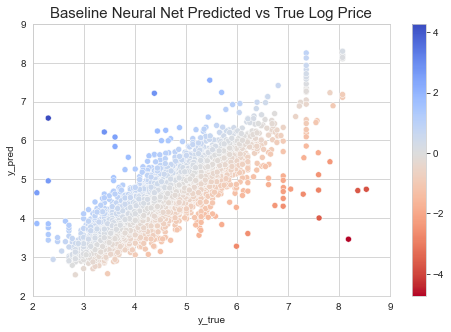

In [240]:
pred = best_model_bl.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Baseline Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

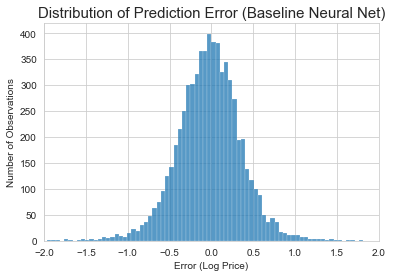

In [241]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Baseline Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

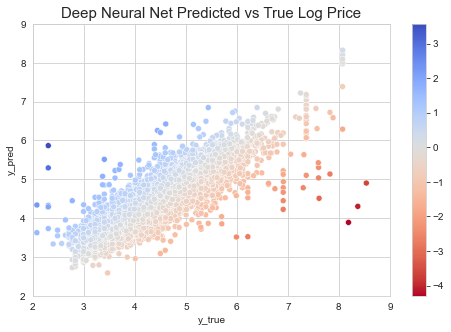

In [242]:
pred = best_model_dp.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Deep Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

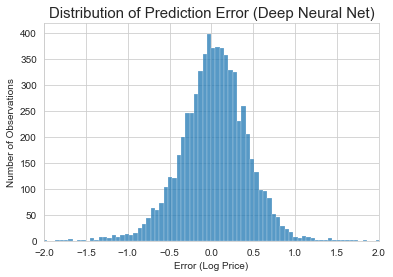

In [243]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Deep Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

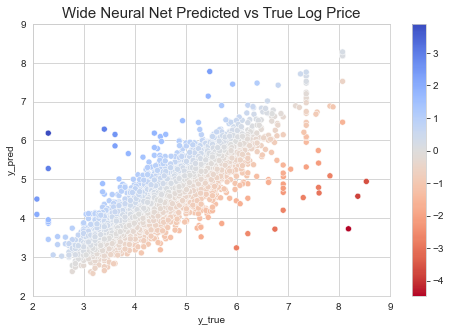

In [244]:
pred = best_model_wd.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Wide Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

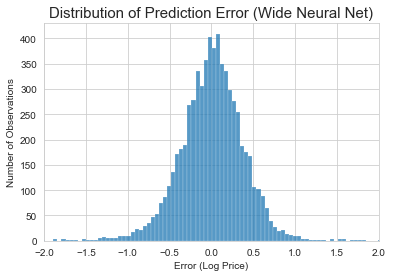

In [245]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Wide Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

## SHAP Values

In [187]:
import shap
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

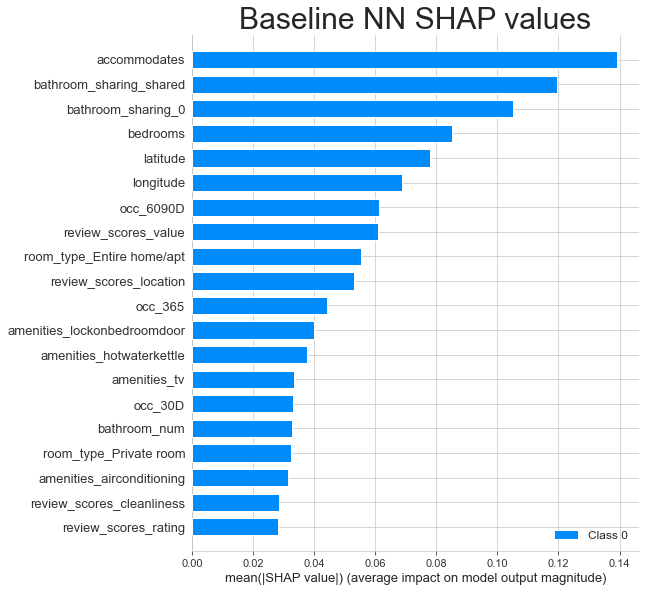

In [246]:
explainer = shap.DeepExplainer(best_model_bl,X_train_trfm[:100])
shap_values = explainer.shap_values(X_train_trfm.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train_trfm, show=False)
plt.title("Baseline NN SHAP values",size=30)
plt.show()

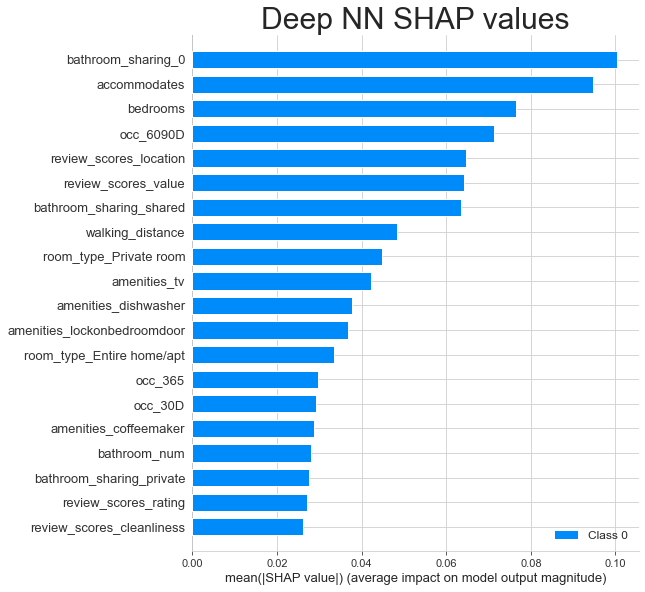

In [247]:
explainer = shap.DeepExplainer(best_model_dp,X_train_trfm[:100])
shap_values = explainer.shap_values(X_train_trfm.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train_trfm, show=False)
plt.title("Deep NN SHAP values",size=30)
plt.show()

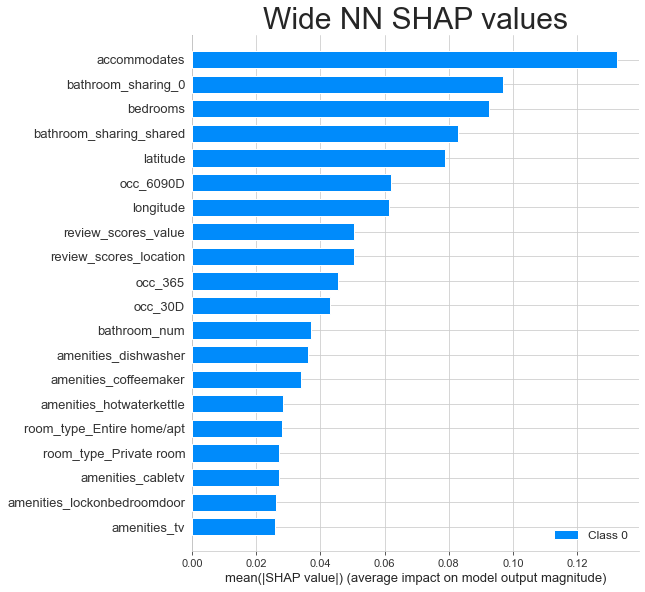

In [248]:
explainer = shap.DeepExplainer(best_model_wd,X_train_trfm[:100])
shap_values = explainer.shap_values(X_train_trfm.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train_trfm, show=False)
plt.title("Wide NN SHAP values",size=30)
plt.show()